<a href="https://colab.research.google.com/github/ludoveltz/BOOK_IA/blob/main/Generateur_primitives_3D_from_simple_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 54.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.

Traitement du prompt: un cylindre de 3cm de rayon et 5cm de hauteur
Type de forme détecté: cylindre
Paramètres extraits: {'hauteur': 30.0, 'rayon': 50.0}
Forme sauvegardée dans: cylindre_generated.stl


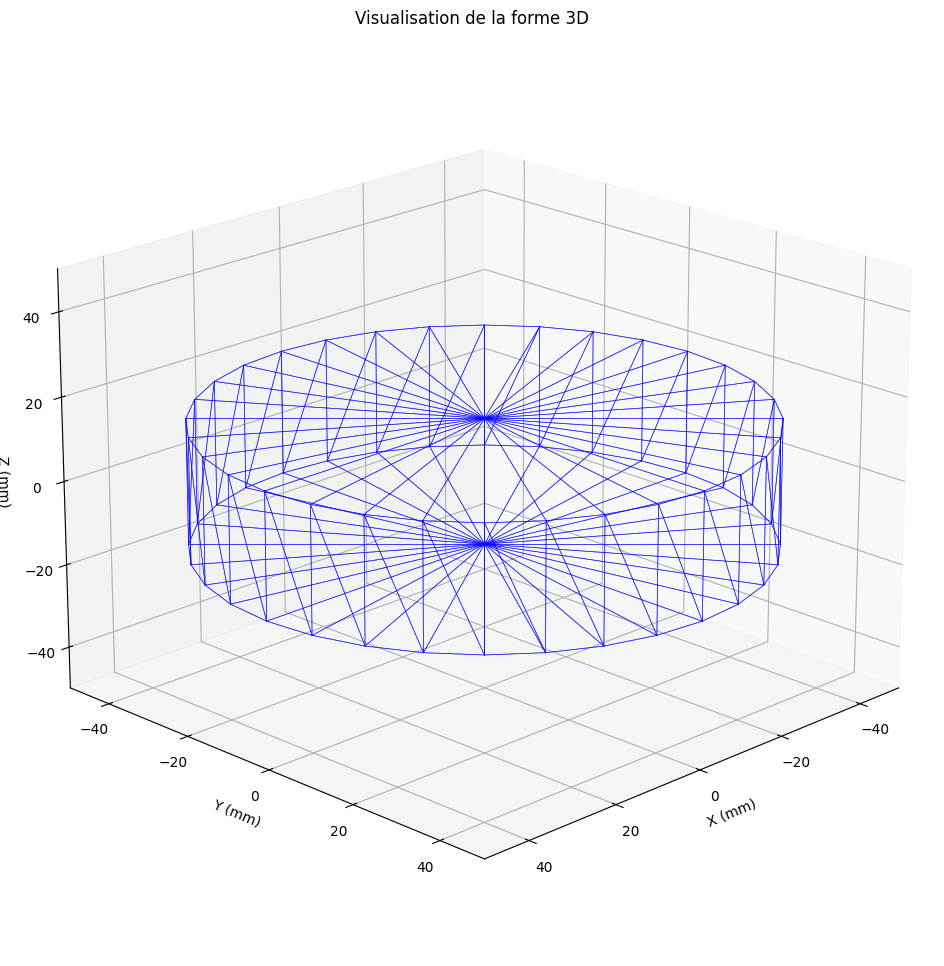


Traitement du prompt: une sphère de 2cm de rayon
Type de forme détecté: sphere
Paramètres extraits: {'rayon': 20.0}
Forme sauvegardée dans: sphere_generated.stl


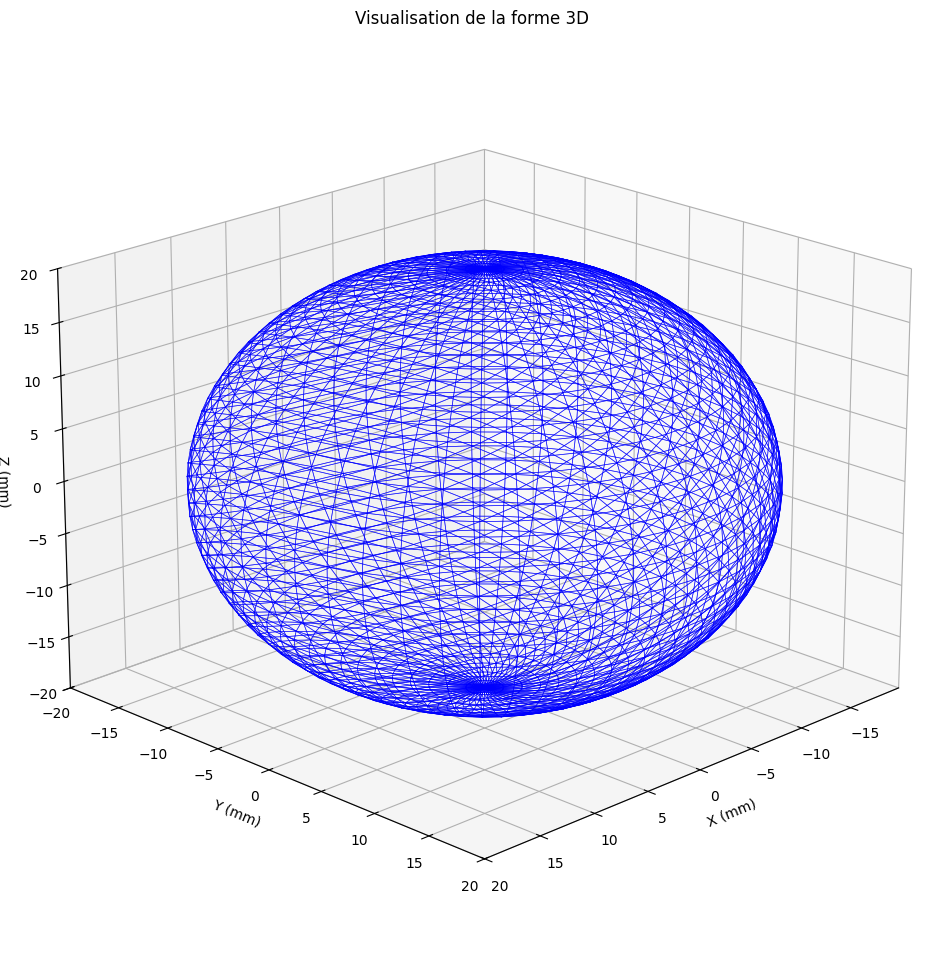


Traitement du prompt: un cube de 4cm de côté
Type de forme détecté: cube
Paramètres extraits: {'côté': 40.0}
Forme sauvegardée dans: cube_generated.stl


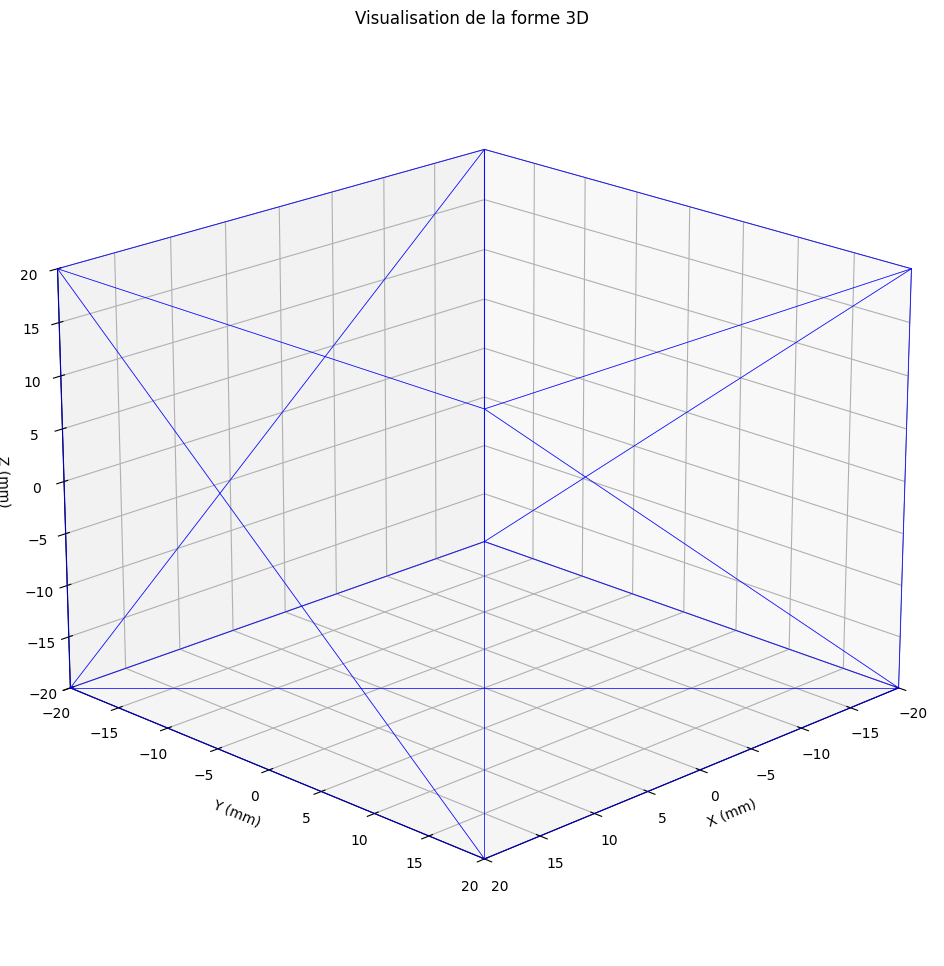


Traitement du prompt: un cone de 2cm de rayon et 6cm de hauteur
Type de forme détecté: cone
Paramètres extraits: {'hauteur': 20.0, 'rayon': 60.0}
Forme sauvegardée dans: cone_generated.stl


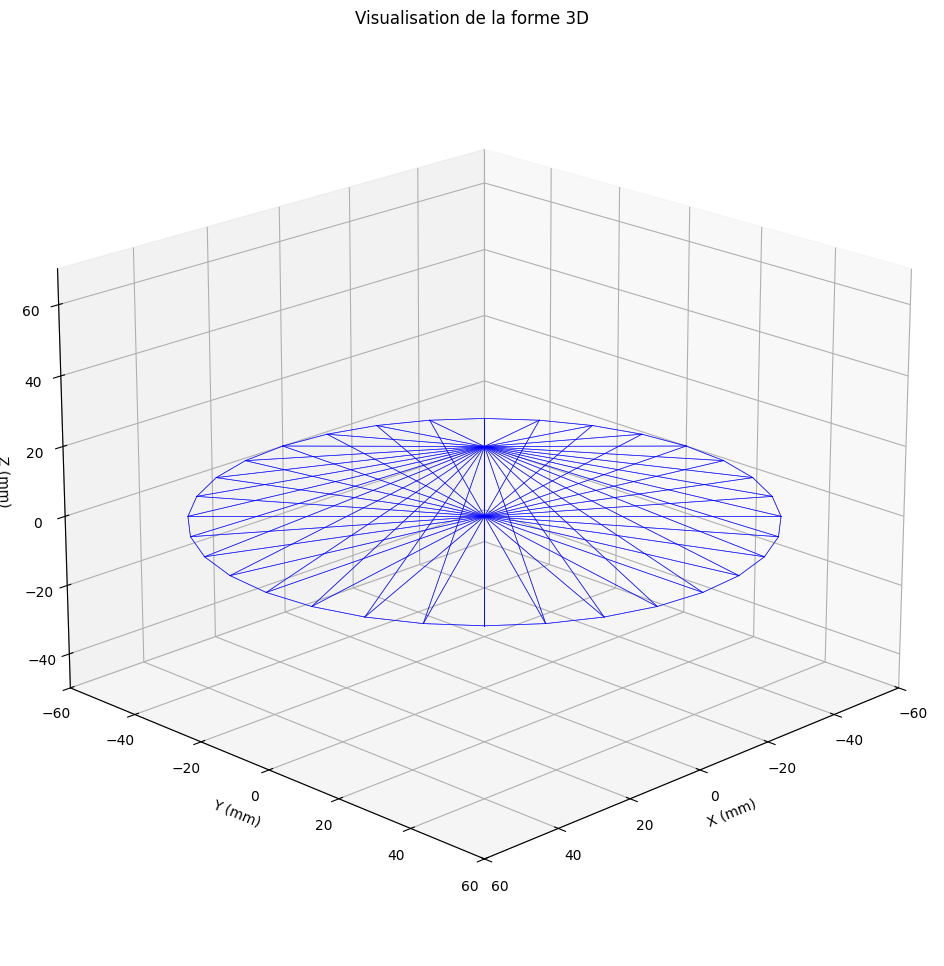

In [5]:
# Installation des bibliothèques nécessaires
!pip install trimesh open3d spacy
!python -m spacy download fr_core_news_sm

import trimesh
import open3d as o3d
import spacy
import re
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Charger le modèle français de spaCy
nlp = spacy.load('fr_core_news_sm')

def visualize_mesh(mesh):
    """Visualiser le mesh avec une meilleure présentation"""
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    vertices = mesh.vertices
    faces = mesh.faces

    # Tracer le wireframe avec des lignes plus visibles
    for face in faces:
        pts = vertices[face]
        for i in range(3):
            start = pts[i]
            end = pts[(i+1)%3]
            ax.plot([start[0], end[0]],
                   [start[1], end[1]],
                   [start[2], end[2]],
                   'b-', linewidth=0.5, alpha=0.7)

    # Configurer les axes
    ranges = [np.max(vertices[:,i]) - np.min(vertices[:,i]) for i in range(3)]
    max_range = max(ranges) / 2.0
    mid_x = (np.max(vertices[:,0]) + np.min(vertices[:,0])) * 0.5
    mid_y = (np.max(vertices[:,1]) + np.min(vertices[:,1])) * 0.5
    mid_z = (np.max(vertices[:,2]) + np.min(vertices[:,2])) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    plt.title('Visualisation de la forme 3D')

    # Améliorer l'angle de vue
    ax.view_init(elev=20, azim=45)
    plt.show()

def create_sphere(radius):
    """Créer une sphère avec une meilleure résolution"""
    # Augmenter la résolution pour une meilleure sphère
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)

    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))

    # Créer les vertices et faces
    vertices = []
    faces = []

    # Ajouter les vertices
    for i in range(len(u)):
        for j in range(len(v)):
            vertices.append([x[i,j], y[i,j], z[i,j]])

    # Créer les faces
    for i in range(len(u)-1):
        for j in range(len(v)-1):
            v0 = i * len(v) + j
            v1 = v0 + 1
            v2 = (i + 1) * len(v) + j
            v3 = v2 + 1
            faces.append([v0, v1, v2])
            faces.append([v1, v3, v2])

    return trimesh.Trimesh(vertices=np.array(vertices), faces=np.array(faces))


class ShapeGenerator:
    def __init__(self):
        self.supported_shapes = {
            'cube': ['côté', 'longueur'],
            'sphere': ['rayon', 'diamètre'],
            'cylindre': ['rayon', 'hauteur', 'diamètre'],
            'cone': ['rayon', 'hauteur', 'diamètre']
        }

    def extract_parameters(self, text):
        text_lower = text.lower()

        # Patterns pour les mesures
        number_pattern = r'(\d+(?:\.\d+)?)\s*(cm|m|mm)'
        measures = re.findall(number_pattern, text_lower)

        # Identifier la forme
        shape = None
        if 'sphere' in text_lower or 'sphère' in text_lower:
            shape = 'sphere'
        elif 'cube' in text_lower:
            shape = 'cube'
        elif 'cylindre' in text_lower:
            shape = 'cylindre'
        elif 'cone' in text_lower or 'cône' in text_lower:
            shape = 'cone'

        # Extraire les paramètres
        params = {}
        for measure in measures:
            value, unit = measure
            # Convertir en mm
            value = float(value) * (10 if unit == 'cm' else 1000 if unit == 'm' else 1)

            if 'hauteur' in text_lower and 'hauteur' not in params:
                params['hauteur'] = value
            elif 'rayon' in text_lower and 'rayon' not in params:
                params['rayon'] = value
            elif 'diamètre' in text_lower and 'rayon' not in params:
                params['rayon'] = value / 2
            elif 'côté' in text_lower and 'côté' not in params:
                params['côté'] = value

        return shape, params

    def create_shape(self, shape_type, params):
        """Créer la forme 3D selon les paramètres avec dimensions corrigées"""
        if shape_type == 'cube':
            side = params.get('côté', 10)
            return trimesh.creation.box(extents=[side, side, side])

        elif shape_type == 'sphere':
            radius = params.get('rayon', 10)
            return create_sphere(radius)

        elif shape_type == 'cylindre':
            radius = params.get('rayon', 10)
            height = params.get('hauteur', 20)
            return trimesh.creation.cylinder(radius=radius, height=height)

        elif shape_type == 'cone':
            radius = params.get('rayon', 10)
            height = params.get('hauteur', params.get('rayon', 20))
            return trimesh.creation.cone(radius=radius, height=height)
        else:
            raise ValueError(f"Forme non supportée: {shape_type}")


def main():
    generator = ShapeGenerator()

    # Exemples de prompts
    test_prompts = [
        "un cylindre de 3cm de rayon et 5cm de hauteur",
        "une sphère de 2cm de rayon",
        "un cube de 4cm de côté",
        "un cone de 2cm de rayon et 6cm de hauteur"
    ]

    for prompt in test_prompts:
        print(f"\nTraitement du prompt: {prompt}")
        try:
            shape_type, params = generator.extract_parameters(prompt)
            print(f"Type de forme détecté: {shape_type}")
            print(f"Paramètres extraits: {params}")

            mesh = generator.create_shape(shape_type, params)
            filename = f"{shape_type}_generated.stl"
            mesh.export(filename)
            print(f"Forme sauvegardée dans: {filename}")

            visualize_mesh(mesh)

        except Exception as e:
            print(f"Erreur lors du traitement: {str(e)}")

if __name__ == "__main__":
    main()

